# **COMP 2211 Exploring Artificial Intelligence**
## Image Classification (CNN)

![fruit.jpg](https://pic.pimg.tw/fsixteenart/1567950247-3939100531_l.png)

**Enable the GPU accelerator in Colab:**

***1. 'Edit' -> 'Notebook settings':***

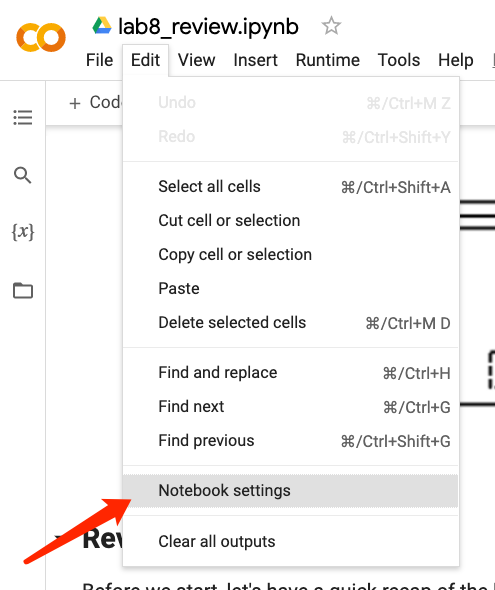


***2. Set 'Hardware accelerator' to 'GPU'***:

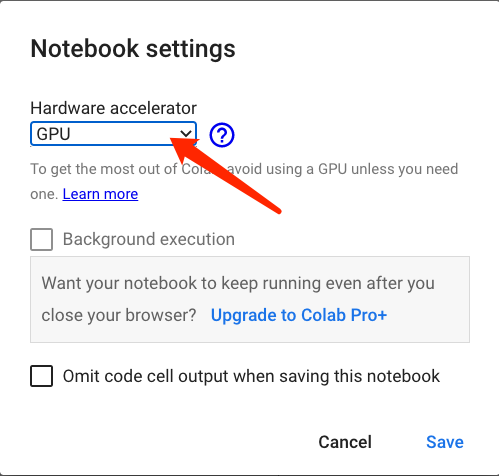

## Check if GPU is enabled

In [35]:
# check your Colab device
import tensorflow as tf  # Import tensorflow library
import pprint            # Import pprint library for better print format
device_name = tf.config.list_physical_devices()  # A list of divece name, which could contain CPU and GPU
pprint.pprint(device_name)                       # Print the device_name

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


***Note:*** If you use GPU too regularly, runtime durations will become shorter and shorter, and disconnections more frequent. The cooldown period before you can connect to another GPU will extend from hours to days to weeks.

## **Lab Tasks Procedure**
0. Data preparation
1. Data preprocessing **(Task 1)**
2. Data generator **(Task 2)**
3. Build the model **(Task 3)**
4. Compile the model
5. Train the model
6. Evaluate the model
7. Save the model

## **Data Preparation**


1. Download the PokemonData from [here](https://course.cse.ust.hk/comp2211/labs/lab8/PokemonData.zip)
2. Upload this data to your Google Drive, under folder `comp2211/lab8`.
3. Run the following code cell to mount Google Drive and unzip the data.

Note: If this lasts for more than three minutes, you may try deleting the previously unzipped folder on Google Drive and try again.



In [36]:
# from google.colab import drive
# drive.mount("/content/drive")
# %cd "drive/MyDrive/comp2211/lab8"
# !unzip -q -o PokemonData.zip -d .
# !ls

## **Pokemon Recognition**
---
About the data:
- Number of images: **6375**.
- Number of classes: **150**.
- Image size: various.

Before data preprocessing, we visualize some of the images to get familiar with the data.

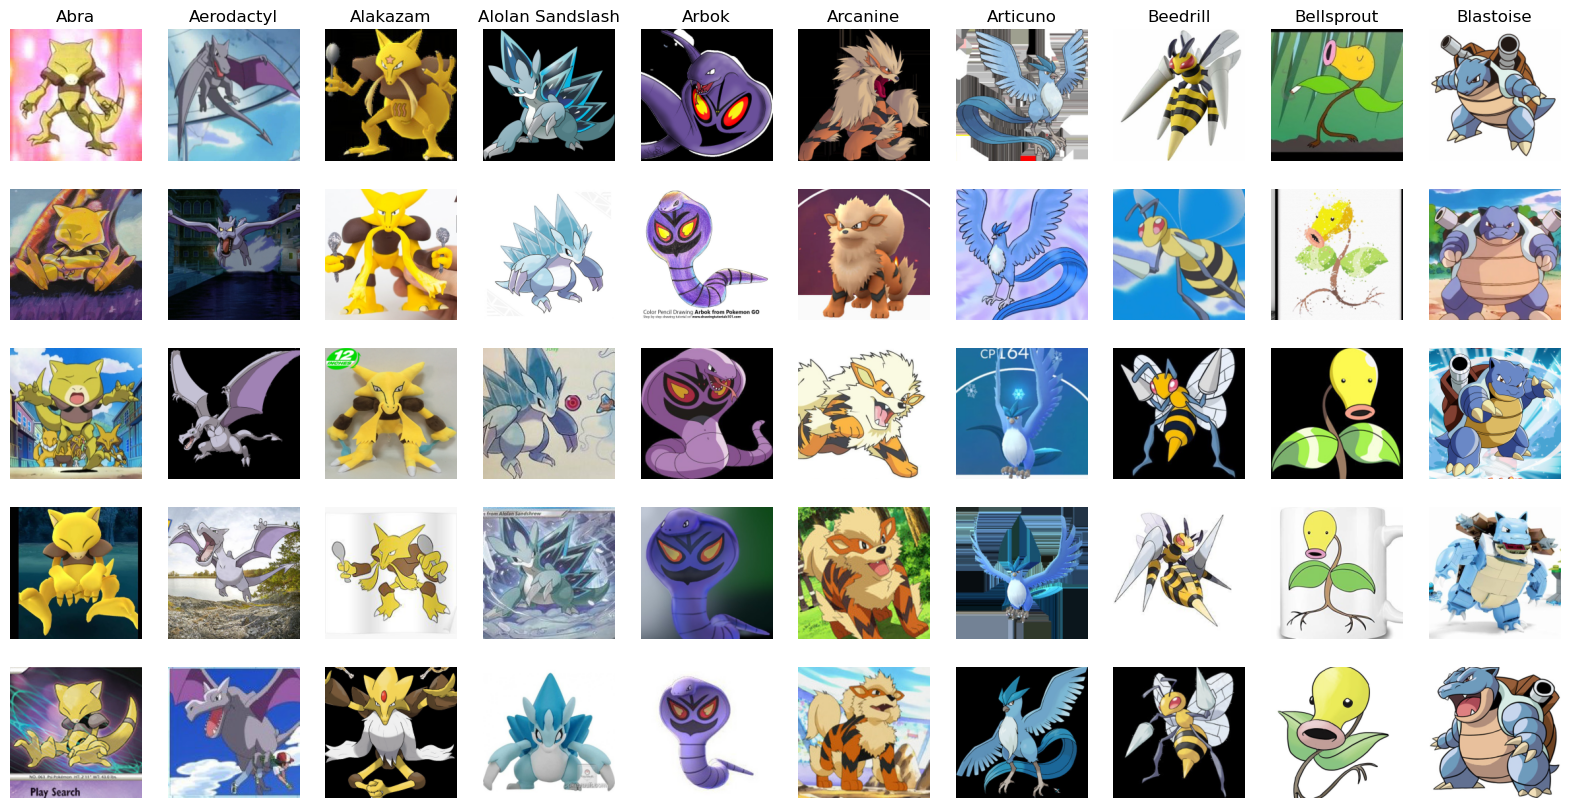

In [37]:
import os, cv2
import matplotlib.pyplot as plt

data_dir = './PokemonData'
# os.list() returns the list of subfolder's name
# sorted() rearranges the order of the list
category_list = sorted(os.listdir(data_dir)) 

plt.figure(figsize=(20,10))
for i in range(10): # we only show first 10 categories
  img_names = sorted(os.listdir('{}/{}'.format(data_dir, category_list[i])))
  for j in range(5): # we only show first 5 images of each category
    img = plt.imread('{}/{}/{}'.format(data_dir, category_list[i], img_names[j])) # read the image
    img = cv2.resize(img,(200, 200),interpolation=cv2.INTER_AREA) # resize them to the same size for convenience
    plt.subplot(5, 10, 10*j+i+1) # plot the same category at the same column
    plt.imshow(img)
    plt.axis('off')
    if j == 0: # only show category name at the first row
      plt.title(category_list[i])
plt.show()


In [38]:
# Import necessary libraries
import numpy as np

from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint

## 1. Data preprocessing

We first construct a mapping from string-type category names to integer-type class indices, for later use.

In [39]:
data_dir = './PokemonData'
# os.list() returns the list of subfolder's name
# sorted() rearranges the order of the list
category_list = sorted(os.listdir(data_dir)) 

# Create a dict mapping the category name to the class index
# The number of label should be 150 (0 to 149)
cate2Idx = {}
for i in range(len(category_list)):
  cate2Idx[category_list[i]] = i
print(cate2Idx)

{'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Alolan Sandslash': 3, 'Arbok': 4, 'Arcanine': 5, 'Articuno': 6, 'Beedrill': 7, 'Bellsprout': 8, 'Blastoise': 9, 'Bulbasaur': 10, 'Butterfree': 11, 'Caterpie': 12, 'Chansey': 13, 'Charizard': 14, 'Charmander': 15, 'Charmeleon': 16, 'Clefable': 17, 'Clefairy': 18, 'Cloyster': 19, 'Cubone': 20, 'Dewgong': 21, 'Diglett': 22, 'Ditto': 23, 'Dodrio': 24, 'Doduo': 25, 'Dragonair': 26, 'Dragonite': 27, 'Dratini': 28, 'Drowzee': 29, 'Dugtrio': 30, 'Eevee': 31, 'Ekans': 32, 'Electabuzz': 33, 'Electrode': 34, 'Exeggcute': 35, 'Exeggutor': 36, 'Farfetchd': 37, 'Fearow': 38, 'Flareon': 39, 'Gastly': 40, 'Gengar': 41, 'Geodude': 42, 'Gloom': 43, 'Golbat': 44, 'Goldeen': 45, 'Golduck': 46, 'Golem': 47, 'Graveler': 48, 'Grimer': 49, 'Growlithe': 50, 'Gyarados': 51, 'Haunter': 52, 'Hitmonchan': 53, 'Hitmonlee': 54, 'Horsea': 55, 'Hypno': 56, 'Ivysaur': 57, 'Jigglypuff': 58, 'Jolteon': 59, 'Jynx': 60, 'Kabuto': 61, 'Kabutops': 62, 'Kadabra': 63, 'Kakuna': 64, 

### **Task 1**

You need to implement the core of the function `data_preprocessing`, which returns the processed images as `x` and the labels as `y`. See more detailed descriptions below.

In [40]:
# Input:
#     data_dir(str)  -- the root folder of the data.
#     cate2Idx(dict) -- a mapping from category name to class index.
#     img_size(int)  -- an integer indicating the size of the preprocessed image (square)
# Return:
#     x(array) -- the images data, the shape in this task should be (num_imgs, img_size, img_size, 3).
#     y(array) -- the label of images, the shape in this task should be (num_imgs,).
# Here are some useful functions that might be useful for you:
#     os.listdir()   -- list all files and directories under a given directory
#     cv2.imread()   -- read image data.
#     cv2.cvtColor() -- convert the color space.
#     cv2.resize()   -- resize an image to a certain shape
def data_preprocessing(data_dir, cate2Idx, img_size):
  x = []
  y = []
  # Note: OpenCV reads an image with its channel being in 'BGR' order,
  # you need to change the order back to 'RGB'.
  ###############################################################################
  # TODO: your code starts here
  category = sorted(os.listdir(data_dir))
  for i in range(len(category)):
    img_names = sorted(os.listdir('{}/{}'.format(data_dir, category[i])))
    for j in range(len(img_names)):
      img = cv2.imread('{}/{}/{}'.format(data_dir, category_list[i], img_names[j]))
      img_resize = cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
      # img_RGB = img_resize[:,:,2::-1]
      img_RGB = cv2.cvtColor(img_resize,cv2.COLOR_BGR2RGB)
      x.append(img_RGB)
      y.append(cate2Idx[category[i]])
  # TODO: your code ends here
  ###############################################################################
  x = np.asarray(x)
  y = np.asarray(y)
  return x, y

Run the following code cell to start data preprocessing.

(6375, 64, 64, 3) (6375,)


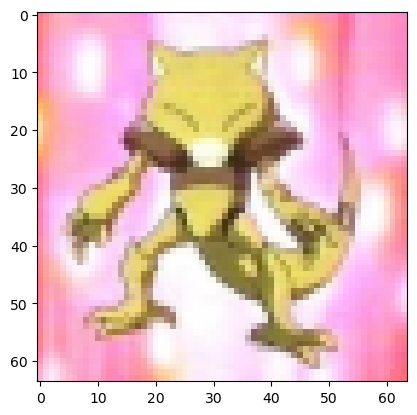

In [41]:
x, y = data_preprocessing(data_dir, cate2Idx, 64) # we use 64x64 as image size in this task, please DO NOT change it
print(x.shape, y.shape)                           # The shape of x should be (6375, 64, 64, 3) and the shape of y should be (6375,)
plt.imshow(x[0])

We further split the data to train and test sets with ratio 4:1 and convert the labels from integer to one-hot encoding with the following code cell.

In [42]:
# Split the dataset to train and test parts with ratio 4:1
# x_train is a NumPy array of RGB image data with shape (5100, 64, 64, 3)
# y_train is a NumPy array of labels (in range 0-149) with shape (5100,)
# x_test is a NumPy array of RGB image data with shape (1275, 64, 64, 3)
# y_test is a NumPy array of labels (in range 0-149) with shape (1275,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# There are 150 classes, represented as unique integers(0 to 149).
# Transform the integer into a 150-element binary vector (i.e., one-hot encoding).
y_train = np_utils.to_categorical(y_train, len(category_list))
y_test = np_utils.to_categorical(y_test, len(category_list))

In [43]:
# Check if the shapes are correct
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5100, 64, 64, 3)
(5100, 150)
(1275, 64, 64, 3)
(1275, 150)


## 2. Data generator

### **Task 2**

You need to add appropriate data augmentations to the data generator to avoid overfitting. By default, the data generator does not contain any data augmentation, but still runnable (you may try the default generator first to see how it performs).

You may find this [webpage](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) useful for adding more augmentations. 

In [44]:
from keras.preprocessing.image import ImageDataGenerator

def get_datagen():
  datagen = None
  ###############################################################################
  # TODO: your code starts here
  datagen = ImageDataGenerator(width_shift_range=0.1,
    rotation_range= 15,
    height_shift_range=0.1,
    # vertical_flip= True,
    horizontal_flip=True,
    validation_split=0.1,
    # data_format='channels_last',
    shear_range=0.1,
    zoom_range=0.1)
  # TODO: your code ends here
  ###############################################################################
  return datagen

Run the following code cell to get a data generator `train_generator`, which will be used to produce augmented data during training.

In [45]:
datagen = get_datagen()   # Instantiate a data generator
datagen.fit(x_train)      # Fit the generator to the training data for normalization
train_generator = datagen.flow(x_train, y_train, batch_size=128) #  The generator will be used during training

## 3. Build the model

### **Task 3** 

You need to build a CNN model for Pokemon recognition. There is no restrict on the number of layers. You can use the following layers:

* Convolution (`Conv2D`)
* Pooling (`MaxPooling2D`, `AveragePooling2D`)
* Fully-connected (`Dense`)
* Dropout (`Dropout`)
* Flatten (`Flatten`)

Please keep the number of total parameters of your model within **less than 10 million.**

For reference, our solution uses around 2 million parameters.

In [46]:
# Hint: The model from the review notebook could be a good starting point.
def custom_model():
  model = None
  ###############################################################################
  # TODO: your code starts here
  model= Sequential()
  model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))
  model.add(Flatten()) 
  # model.add(Dropout(0.2))
  model.add(Dense(units=170, activation='relu'))
  # model.add(Dropout(0.2))
  model.add(Dense(units=150, activation='softmax'))

  model.build()
  # TODO: your code ends here
  ###############################################################################
  return model


# Create the model (DO NOT include this in the submission file)
model = custom_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 8)         224       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        1168      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 64)       

## 4. Compile the Model

In [47]:
# Compile the model
# Use crossentropy loss function since there are two or more label classes
# Use adam algorithm (a stochastic gradient descent method)
# Use accuracy as metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.save('model_lab8.init.h5', save_format='h5')

## 5. Train the model

Run the following code cell to start training.

In [48]:
model = keras.models.load_model('model_lab8.init.h5')  # Reset the model to last compilation

checkpoint_callback = ModelCheckpoint(
    filepath='model_lab8.temp.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)  # Save the model with the best validation accuracy seen so far at each epoch

history = model.fit(train_generator,
         validation_data=(x_test, y_test),
         steps_per_epoch=len(x_train) / 128, epochs=60, # By default the model is trained with 60 epochs
         callbacks=[checkpoint_callback])               # You don't have to change the number of epochs, but you may do so if it is necessary

Epoch 1/60
39/39 [==============================] - 9s 211ms/step - loss: 5.9970 - accuracy: 0.0086 - val_loss: 4.9376 - val_accuracy: 0.0102
Epoch 2/60
39/39 [==============================] - 10s 240ms/step - loss: 4.8306 - accuracy: 0.0212 - val_loss: 4.6355 - val_accuracy: 0.0329
Epoch 3/60
39/39 [==============================] - 10s 252ms/step - loss: 4.4700 - accuracy: 0.0400 - val_loss: 4.1868 - val_accuracy: 0.0510
Epoch 4/60
39/39 [==============================] - 10s 262ms/step - loss: 4.0608 - accuracy: 0.0694 - val_loss: 3.8820 - val_accuracy: 0.0800
Epoch 5/60
39/39 [==============================] - 11s 274ms/step - loss: 3.7677 - accuracy: 0.1016 - val_loss: 3.4159 - val_accuracy: 0.1514
Epoch 6/60
39/39 [==============================] - 9s 224ms/step - loss: 3.4804 - accuracy: 0.1492 - val_loss: 3.2061 - val_accuracy: 0.2157
Epoch 7/60
39/39 [==============================] - 10s 246ms/step - loss: 3.2891 - accuracy: 0.1839 - val_loss: 2.8698 - val_accuracy: 0.2784
E

## 6. Evaluate the model

In [49]:
model = keras.models.load_model('model_lab8.temp.h5')          # Restore the best model
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)  # 'verbose=0' means no progress bar
print('Validation loss: {}'.format(val_loss))
print('Validation accuracy: {}'.format(val_acc))

Validation loss: 1.4083847999572754
Validation accuracy: 0.6643137335777283


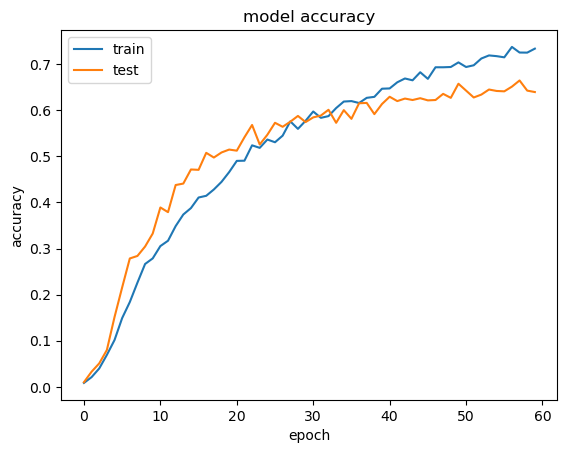

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 7. Save the model

Run the following code cell to save your model.

In [51]:
# Save the mdoel to an HDF5 file
model_name = 'model_lab8.h5'              # Define model name
model.save(model_name, save_format='h5')  # Save the model

## **ZINC Submission**

1. Copy your code of Task 1, 2, and 3 to the corresponding functions in the submission template `lab8_task.py`
2. Download your trained model `model_lab8.h5`. 
3. Zip the `lab8_task.py` and `model_lab8.h5` to a single zip file named `lab8_task.zip`
4. **Submit the ``.zip`` file** to ZINC.

## **Grading scheme**
* You get **1 point** for achieving at least **45%** accuracy on our private test set.
* You get **1.5 points** for achieving at least **55%** accuracy on our private test set.
* You get **2 points** (full mark) for achieving at least **60%** accuracy on our private test set.

**Note:** The accuracy on our private test set will be similar to the validation accuarcy that you see above. While there may be some difference, a **3%** margin should be safe. In other words, if you wish to get a full mark, then your validation accuracy should be at least **63%**.